In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from chainer import cuda, Variable, FunctionSet, optimizers
import chainer.functions as F
import sys
import csv
from pprint import pprint 

plt.style.use('ggplot')

In [27]:
# 確率的勾配降下法におけるミニバッチ数
batchsize = 50

# 学習の繰り返し回数
n_epoch = 20

# 中間層の数
n_units = 4


#=================================================
# csvファイルからデータを取り出し、listに格納
def set_data():

        filename = "../../../data/misyo/data_standardized"
        
        f = open('%s.csv' % filename, 'rU')
        data = csv.reader(f)

        data_set = []
        target_set = []
        for line in data:
                data_set.append(line[1:3])
                target_set.append(line[4])
        f.close()
        np_dataSet = np.array(data_set, dtype=np.float32)
        np_targetSet = np.array(target_set, dtype=np.int32)
        return np_dataSet, np_targetSet

#=================================================

data, target = set_data()

# <!--- start_debug
#print data.shape
#print target.shape
#       end_debug ----> 


# 学習用データをN個、検証用データを残りの個数と設定
# Nの値は暫定的なもの
N = 1200
x_train, x_test = np.split( data, [N])  
y_train, y_test = np.split( target, [N]) 
N_test = y_test.size
#print data
#print target



In [28]:
# 多層パーセプトロンモデルの設定
# 入力 2次元、出力 2次元
model = FunctionSet(l1=F.Linear(2, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 2))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True ):
        x, t = Variable(x_data), Variable(y_data)
        h1 = F.dropout(F.relu(model.l1(x)), ratio=.0, train=train)
        h2 = F.dropout(F.relu(model.l2(h1)), ratio=.0, train=train)
        y = model.l3(h2)
        # 0/1の2クラス分類なので誤差関数として、ソフトマックス関数
        # を用いて、誤差を導出
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)



In [29]:
# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

train_loss = []
train_acc= []
test_loss = []
test_acc = []

l1_W = np.array('1')
l2_W = []
l3_W = []



epoch 1
train mean loss=0.645430328945, accuracy=0.518333333234
test  mean loss=0.648901032847, accuracy=0.583914727435
epoch 2
train mean loss=0.611342390378, accuracy=0.616666669647
test  mean loss=0.614220259726, accuracy=0.658139536778
epoch 3
train mean loss=0.583392200371, accuracy=0.710833335916
test  mean loss=0.582662284836, accuracy=0.761821699697
epoch 4
train mean loss=0.558359024425, accuracy=0.77083333085
test  mean loss=0.556854495938, accuracy=0.793992239375
epoch 5
train mean loss=0.537813428789, accuracy=0.782499996324
test  mean loss=0.532319918852, accuracy=0.799612400606
epoch 6
train mean loss=0.518719986081, accuracy=0.786666661501
test  mean loss=0.515479038852, accuracy=0.794379840526
epoch 7
train mean loss=0.504036571831, accuracy=0.790833329161
test  mean loss=0.502057045467, accuracy=0.793604647466
epoch 8
train mean loss=0.492811246465, accuracy=0.789999994139
test  mean loss=0.493855861037, accuracy=0.792054259038
epoch 9
train mean loss=0.484136876961, a

[]

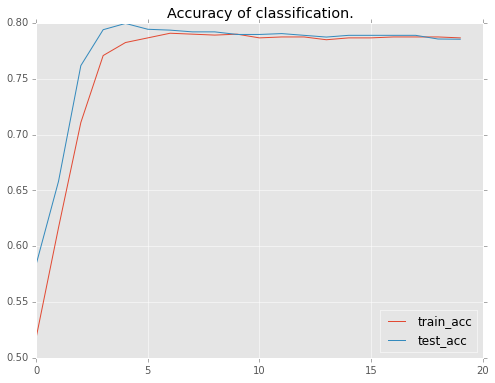

In [30]:
# Learning loop
for epoch in xrange(1, n_epoch+1):
        print 'epoch', epoch

        # training
        # N個の順番をランダムに並び替える
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        # 0〜Nまでのデータをバッチサイズごとに使って学習
        for i in xrange(0, N, batchsize):
                x_batch = x_train[perm[i:i+batchsize]]
                y_batch = y_train[perm[i:i+batchsize]]

                # 勾配を初期化
                optimizer.zero_grads()
                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch)
                # 誤差逆伝播で勾配を計算
                loss.backward()
                optimizer.update()
                
                sum_loss += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # 訓練データの誤差と、正解精度を表示
        print 'train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N)
                
        train_loss.append(sum_loss / N)
        train_acc.append(sum_accuracy / N)


        # evaluation
        # テストデータで誤差と、正解精度を算出し汎化性能を確認
        sum_accuracy = 0
        sum_loss     = 0
        for i in xrange(0, N_test, batchsize):
                x_batch = x_test[i:i+batchsize]
                y_batch = y_test[i:i+batchsize]

                # 順伝播させて誤差と精度を算出
                loss, acc = forward(x_batch, y_batch, train=False)
          


                sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
                sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

        # テストデータでの誤差と、正解精度を表示
        print 'test  mean loss={}, accuracy={}'.format(sum_loss / N_test, sum_accuracy / N_test)
        test_loss.append( sum_loss / N_test)
        test_acc.append( sum_accuracy / N_test)
        

        
        # 学習したパラメーターを保存
        #l1_W.append(model.l1.W)
        l2_W.append(model.l2.W)
        l3_W.append(model.l3.W)
        
        l1_W = np.append( l1_W, model.l1.W)
        
                      
        #pprint(vars(model.l1))
        #pprint(model.l1.W[0:2])

        # 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of classification.")
plt.plot()


In [32]:
# 学習したパラメータを出力
print l1_W

#print l2_W
#print l3_W

['1' '0.76402926445' '-0.151047363877' '1.54851984978' '1.58456599712'
 '-0.203131169081' '-0.795029342175' '-1.34399116039' '-0.959085702896'
 '0.743932306767' '-0.170784682035' '1.57655441761' '1.60542416573'
 '-0.223172053695' '-0.8119135499' '-1.36384785175' '-0.974154889584'
 '0.725794434547' '-0.188770934939' '1.60806274414' '1.63890266418'
 '-0.243168398738' '-0.827261924744' '-1.38412594795' '-0.989268183708'
 '0.71069008112' '-0.204190015793' '1.64021623135' '1.67406523228'
 '-0.257964462042' '-0.840009391308' '-1.3997528553' '-1.00379514694'
 '0.697593986988' '-0.22104151547' '1.67254471779' '1.70953667164'
 '-0.274872243404' '-0.851290106773' '-1.41892659664' '-1.01639914513'
 '0.687832653522' '-0.236526787281' '1.70246446133' '1.7420347929'
 '-0.288199722767' '-0.857875704765' '-1.43479812145' '-1.02351558208'
 '0.680251002312' '-0.250966966152' '1.73063921928' '1.77081656456'
 '-0.29885327816' '-0.862981557846' '-1.44871211052' '-1.03035533428'
 '0.673786818981' '-0.263810

In [34]:
pprint(vars(model.l1))
pprint(vars(model.l2))
pprint(vars(model.l3))

{'W': array([[ 0.67075658, -0.36011034],
       [ 1.86937022,  1.98478532],
       [-0.32683006, -0.85341007],
       [-1.52372026, -1.02978194]], dtype=float32),
 'b': array([-0.04065826,  0.31251577,  0.18102182,  0.16028963], dtype=float32),
 'gW': array([[ 0.00271892,  0.01552649],
       [-0.02282235,  0.00226577],
       [-0.00088742, -0.00668106],
       [ 0.00995978, -0.01220092]], dtype=float32),
 'gb': array([ 0.01934317, -0.02534659, -0.00315169,  0.00108118], dtype=float32)}
{'W': array([[ 0.03110179,  0.45313156,  0.66528207, -0.5984835 ],
       [-1.63883388, -0.0643082 ,  0.85649139,  0.17112835],
       [ 0.48958284,  0.46266037,  0.067709  ,  0.19110622],
       [ 1.64374232, -0.06135821,  0.15733866,  0.79996759]], dtype=float32),
 'b': array([ 0.18531892,  0.0966276 ,  0.20257239, -0.10087274], dtype=float32),
 'gW': array([[ -1.45624327e-02,  -5.91204017e-02,  -6.36432180e-03,
          3.84675874e-03],
       [  8.85189883e-03,  -1.52549278e-02,   1.05648832e-02,
 